In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

# $U(x_1, x_2, x_3) = \frac{q V^2}{m \Omega_{RF}^2 r_0^4}(x_1^2 + x_2^2 + 4 x_3^2)$

In [4]:
q = 1 #1.6e-19
V = 300
m = 1 #2.89e-25
omegaRF = 2*np.pi*40e6
rnot = 512e-6
A = 1e3 # q**2 * V**2/(m * omegaRF**2 * rnot**4)
wsec = np.sqrt(2*A/m)
print 'Secular freq = ', wsec/2/np.pi

Secular freq =  7.11762543417


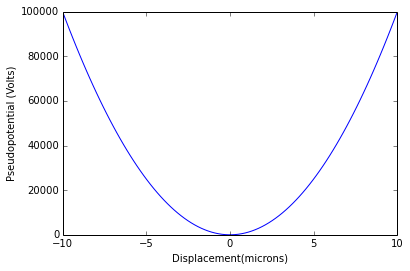

In [5]:
x = np.linspace(-10,10,100)
y = np.linspace(10,-10,100)
xx, yy = np.meshgrid(x,y)
phi = A*(xx**2 + yy**2)
plt.plot(x, A/q*x**2)
plt.ylabel('Pseudopotential (Volts)')
plt.xlabel('Displacement(microns)')
plt.show()


In [36]:
 def ion_distance(ion1, ion2):
    d = np.sqrt((ion1.x - ion2.x)**2 + (ion1.y - ion2.y)**2)
    return d

def interaction_energy(particle, otherions):
    Eint = 0
    for otherion in otherions:
        x_sep = otherion.x - particle.x
        y_sep = otherion.y - particle.y
        d = np.sqrt(x_sep**2 + y_sep**2)
        Eint += 1/d
    return Eint

def pos_energy(particle):
    pos_E = A * (particle.x**2 + particle.y**2 )
    return pos_E

def total_energy(ions):
    E_tot = 0
    for i, particle in enumerate(ions):
        otherions = ions[:i] + ions[i+1 :]
        E_tot += interaction_energy(particle, otherions)
        E_tot += pos_energy(particle)
    return E_tot
    

def plot_ions(ions, colors = None):
    x = []
    y = []
    for i, particle in enumerate(ions):
        x.append(particle.x)
        y.append(particle.y)
    plt.axes().set_aspect('equal', 'datalim')
    if colors:
        plt.scatter(np.array(x),np.array(y), c = colors) # in microns
    else: 
        plt.scatter(x,y)
    
class ion():
    def __init__(self, x0 = 0, y0= 0, ax0=0,ay0=0):
        self.x0= x0
        self.x = self.x0
        self.y0 = y0
        self.y = self.y0

# $$\ddot{\vec{x}}_{ij} = \frac{-2qA}{m}x_{ij} - \frac{q^2}{4 \pi \epsilon_0}\sum_{k\neq j}^{N} \frac{\hat{x}_{ij}\cdot \hat{r}}{|\vec{x}_k-\vec{x}_j|^2}$$

2048.6450031
<built-in function iter>
ion:  0
Starting position: (0.04575040964941268, 0.2104558898932558)
Final Pos (-0.06343789688513057, 0.18310307936469625)
ion:  1
Starting position: (0.08599236476877836, -0.27036862820733654)
Final Pos (-0.004915665455531799, -0.17536891868715337)
ion:  2
Starting position: (0.20556348023979654, -0.18456375237038358)
Final Pos (0.15425220387580588, 0.08342237918762484)
ion:  3
Starting position: (0.27849295138445274, 0.18569663840531803)
Final Pos (0.07370145753842448, 0.1794471504577559)
ion:  4
Starting position: (0.04472830514744819, -0.03474816550081217)
Final Pos (0.05969308233512027, -0.03729678168299177)
ion:  5
Starting position: (-0.04272353170406329, 0.15025740855769976)
Final Pos (0.0023043666560177323, 0.07047855508043172)
ion:  6
Starting position: (-0.17065944609406547, -0.2445227337144512)
Final Pos (-0.06224229467764315, -0.033153295882559934)
ion:  7
Starting position: (0.3479605038310907, -0.49451579995102257)
Final Pos (0.11857

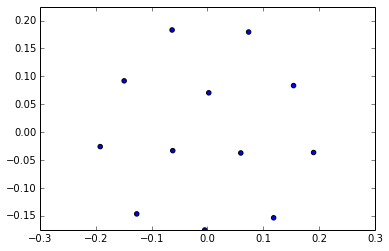

In [100]:
N = 12
pos_spread = 1
number_iters = 20000
step_size = pos_spread*.008

epsilon = 8.8e-12
k = 1 #1/(m * 4*np.pi*epsilon) Superior highly composite number* q**2 

ions = []
for i in range(N):
    x0 = (np.random.rand() - 0.5)*pos_spread
    y0 = (np.random.rand() - 0.5)*pos_spread
    ions.append(ion(x0,y0))

E0 = total_energy(ions)
print E0
    
iters = 0
E = [E0]
last_E = E0

while iters < number_iters:
    iters +=1
    for i, particle in enumerate(ions):
        particle.lastx = particle.x
        particle.x = particle.x + (np.random.rand() - 0.5)*step_size
        particle.lasty = particle.y
        particle.y = particle.y + (np.random.rand() - 0.5)*step_size
        tot_E = total_energy(ions)
        if tot_E < last_E:
            E.append(tot_E)
            last_E = tot_E
        else:
            particle.x = particle.lastx
            particle.y = particle.lasty
        
print iter
for k, particle in enumerate(ions):
    print "ion: ", k
    print "Starting position:",str((particle.x0, particle.y0))
    print "Final Pos", str((particle.x, particle.y))
#r = np.transpose(np.sqrt(np.array(posx)**2 + np.array(posy)**2))
#print 
#plt.plot(E)

#print 'iterations = ',len(E)
#print 'Final Energy = ', E[-1]
#plt.show() 
#plt.plot(r, '--')
#plt.xlim([iter - 50,iter])
#plt.ylim([0.5*np.min(r[iter-50:iter]), 2*np.max(r[iter-50:iter])])
#plt.show()rate(ions)
plot_ions(ions)
plt.savefig('simulated_%s_ion_.pdf' % str(N))
plt.show() 

In [96]:
E[-1]

998.54789390852216

In [92]:
E[-1]

997.95550906683468

In [94]:
E[-1]

998.54918983127823